在给出的CIFAR-10图像集上进行SIFT特征提取，并基于所提取特征在数据集上进行图像特征匹配，找出最相似的图片。

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [10]:
# 初始化图片滤波
SIFT_INIT_SIGMA=0.5
# 尺度内滤波
SIFT_SIGMA=1.6
# 尺度个数-3
SIFT_INTVLS=3
# 精确过滤极值点
SIFT_CONTR_THR=0.04
# 删除边缘效应
SIFT_CURV_THR=10
# 边界
SIFT_IMG_BORDER=5
# 计算子像素点与近似特征点间的偏移量次数
SIFT_MAX_INTERP_STEPS=5
# 方向个数
SIFT_ORI_HIST_BINS=36
# 计算某点的方向直方图时控制周围区域范围
SIFT_ORI_SIG_FCTR=1.5
# 范围 = 3sigma
SIFT_ORI_RADIUS=3.0*SIFT_ORI_SIG_FCTR
# 平滑次数
SIFT_ORI_SMOOTH_PASSES=2
# 辅助方向的值为最大值的80%
SIFT_ORI_PEAK_RATIO=0.8
# 描述符方向个数
SIFT_DESCR_HIST_BINS=8
# 描述符选取2×2为一个种子点
SIFT_DESCR_WIDTH=2
# 用于确定直方图宽度
SIFT_DESCR_SCL_FCTR=3.0
# 截断较大的梯度值
SIFT_DESCR_MAG_THR=0.2
# 特征向量因子
SIFT_INT_DESCR_FCTR=512.0
# 匹配阈值
SIFT_MATCH_THR=0.2

In [11]:
sigma=SIFT_SIGMA
intvls=SIFT_INTVLS
contr_thr=SIFT_CONTR_THR
curv_thr=SIFT_CURV_THR
descr_width=SIFT_DESCR_WIDTH
descr_hist_bins=SIFT_DESCR_HIST_BINS

In [12]:
test_img_path = "./cifar-10/test/0/0_3.jpg"

In [13]:
img1=cv2.imread("./cifar-10/test/0/0_3.jpg").copy()
img1.shape
# img1 = img1.transpose((2, 1, 0))

(32, 32, 3)

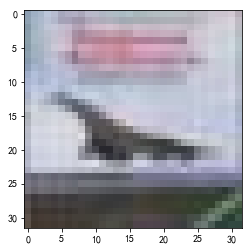

In [14]:
def img_cv2plt(img):
    if img.ndim==2:
        return img
    elif img.ndim==3:
        return np.concatenate([img[:, :, 2, np.newaxis],
                               img[:, :, 1, np.newaxis],
                               img[:, :, 0, np.newaxis]], axis = 2)
    else:
        return None
def show(img, title=""):
    img = img_cv2plt(img)
    plt.figure()
    plt.title(title)
    if img.ndim==2:
        plt.imshow(img, cmap ='gray')
    elif img.ndim==3:
        plt.imshow(img)
plt.imshow(img_cv2plt(img1))

In [15]:
def convert_to_grayfloat(img):
    if img.ndim==3:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img.astype(np.float64)/255.0 

(64, 64)


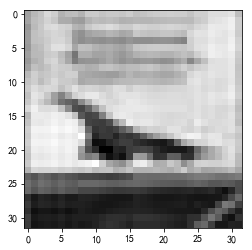

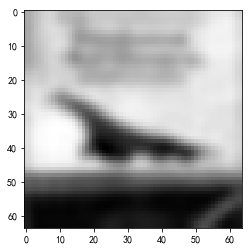

In [16]:
a = convert_to_grayfloat(img1)
# SIFT_INIT_SIGMA=0.5
def create_init_img(img,sigma):
    """
    预处理图像
    """
    img=cv2.resize(img,(img.shape[1]*2,img.shape[0]*2),cv2.INTER_CUBIC)
    sigma=np.sqrt(sigma**2-(SIFT_INIT_SIGMA**2)*4)
    img=cv2.GaussianBlur(img,(0,0),sigma)
    return img
init_img = create_init_img(a, sigma)
print(init_img.shape)
show(a)
show(init_img)

In [17]:
height, width=init_img.shape
# octaves为尺度的个数，即金字塔的层数
octaves = np.int(np.log2(min(height, width))) - 2
octaves

4

![](./img/1.png)

尺度的个数建议为6，分别经过方差为$\sigma, \sigma k^1, \sigma k^2, \dots , \sigma k^5$的高斯滤波，并且规定$k=2^{1/s}$，$s$为尺度的个数，这里为4

In [18]:
def down_sample(img):
    # 对img降采样
    return cv2.resize(img,
                      (img.shape[1] // 2, img.shape[0] // 2), 
                      cv2.INTER_NEAREST)
def build_gauss_pyr(img,octaves,intvls,sigma):
    """
    建立高斯金字塔
    octaves为尺度的个数，即金字塔的层数，论文中用s表示，这里为4
    intvls是单尺度中图片的个数，建议为6
    sigma建议为1.6
    """
    k = 2.0 ** (1.0/intvls)
    sig = [0] * (intvls+3)
    sig[0] = sigma
    sig[1] = sigma*np.sqrt(k*k-1)
    gauss_pyr = [[0 for i in range(intvls+3)] for j in range(octaves)]
    # gauss_pyr.shape == (4, 6) 即(octaves, 6)
    for i in range(2,intvls+3):
        sig[i] = sig[i-1]*k
    # sig = [sigma, sigma*k^1, sigma*k^2, ... , sigma*k^5]
    for i in range(octaves):
        for j in range(intvls + 3):
            if i == 0 and j == 0:
                gauss_pyr[i][j] = img
            elif j == 0:
                gauss_pyr[i][j] = down_sample(gauss_pyr[i-1][intvls])
            else:
                gauss_pyr[i][j] = cv2.GaussianBlur(gauss_pyr[i][j-1],(0,0),sig[j])
    return gauss_pyr

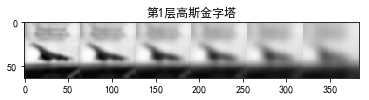

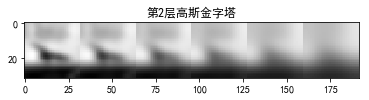

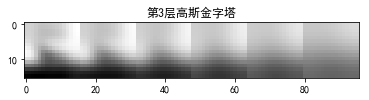

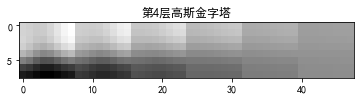

In [19]:
gauss_pyr=build_gauss_pyr(init_img,octaves,intvls,sigma)
assert len(gauss_pyr) == 4 and len(gauss_pyr[0]) == 6
for i in range(octaves):
    show(np.hstack(gauss_pyr[i]), "第{}层高斯金字塔".format(i + 1))

![](./img/2.jpg)

In [20]:
def build_dog_pyr(gauss_pyr,octaves,intvls):
    """
    建立DoG金字塔
    """
    dog_pyr=[[0 for i in range(intvls+2)] for j in range(octaves)]
    for i in range(octaves):
        for j in range(intvls+2):
            # 高斯金字塔相邻相减
            dog_pyr[i][j]=gauss_pyr[i][j+1] - gauss_pyr[i][j]
    return dog_pyr

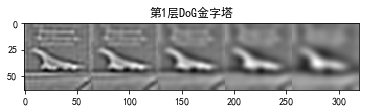

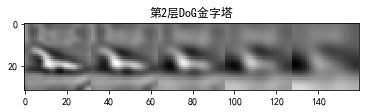

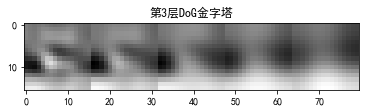

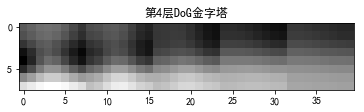

In [21]:
dog_pyr=build_dog_pyr(gauss_pyr,octaves,intvls)
assert len(dog_pyr) == 4 and len(dog_pyr[0]) == len(gauss_pyr[0]) - 1
for i in range(octaves):
    show(np.hstack(dog_pyr[i]), "第{}层DoG金字塔".format(i + 1))

In [22]:
class Feature(object):
    """
    特征
    """
    def __init__(self,x,y,i,j,r,c,sj,scl=0,scl_octv=0):
        self.x = x
        self.y = y
        self.i = i
        self.j = j
        self.r = r
        self.c = c
        self.sj = sj
        self.scl = scl
        self.scl_octv = scl_octv
        self.descr = []

![](./img/3.png)
一个目标点就同周边26个点比较判断是否为极值点

In [23]:
def is_extrema(dog_pyr,i,j,r,c):
    """
    判断是否为极值点
    """
    val = dog_pyr[i][j][r][c]
    for x in range(-1,2):
        for y in range(-1,2):
            for z in range(-1,2):
                if val >= 0 and val<dog_pyr[i][j+x][r+y][c+z]:
                    return False
                elif val<0 and val>dog_pyr[i][j+x][r+y][c+z]:
                    return False
    return True

离散点并不能代表是真正意义上的极大极小值，需要精确定位极值点
![](./img/4.png)

利用已知的离散空间点插值得到的连续空间极值点的方法叫做子像素插值（Sub-pixel Interpolation）为了提高关键点的稳定性，需要对尺度空间DoG函数进行曲线拟合。
DoG函数在尺度空间的Taylor展开式(拟合函数)为：
$$
\mathrm{D}(\mathrm{x})=\mathrm{D}+\frac{\partial \mathrm{D}^{\mathrm{T}}}{\partial \mathrm{x}} \mathrm{x}+\frac{1}{2} \mathrm{x}^{\mathrm{T}} \frac{\partial^{2} \mathrm{D}}{\partial \mathrm{x}^{2}}
$$

其中，$X=(x, y, \sigma)^{T}$，求导并让方程等于零，可以得到极值点的偏移量为：
$$
\hat{X}=-\frac{\partial^{2} D^{-1}}{\partial X^{2}} \frac{\partial D}{\partial X}
$$

In [24]:
def deriv_3D(dog_pyr,i,j,r,c):
    dx=(dog_pyr[i][j][r][c+1]-dog_pyr[i][j][r][c-1])/2.0
    dy=(dog_pyr[i][j][r+1][c]-dog_pyr[i][j][r-1][c])/2.0
    ds=(dog_pyr[i][j+1][r][c]-dog_pyr[i][j-1][r][c])/2.0
    return np.array([[dx],[dy],[ds]])

def hessian_3D(dog_pyr,i,j,r,c):
    v=dog_pyr[i][j][r][c]
    dxx=dog_pyr[i][j][r][c+1]+dog_pyr[i][j][r][c-1]-2*v
    dyy=dog_pyr[i][j][r+1][c]+dog_pyr[i][j][r-1][c]-2*v
    dss=dog_pyr[i][j+1][r][c]+dog_pyr[i][j-1][r][c]-2*v
    dxy=(dog_pyr[i][j][r+1][c+1]-dog_pyr[i][j][r+1][c-1]-dog_pyr[i][j][r-1][c+1]+dog_pyr[i][j][r-1][c-1])/4.0
    dxs=(dog_pyr[i][j+1][r][c+1]-dog_pyr[i][j+1][r][c-1]-dog_pyr[i][j-1][r][c+1]+dog_pyr[i][j-1][r][c-1])/4.0
    dys=(dog_pyr[i][j+1][r+1][c]-dog_pyr[i][j+1][r-1][c]-dog_pyr[i][j-1][r+1][c]+dog_pyr[i][j-1][r-1][c])/4.0
    return np.array([[dxx,dxy,dxs],
                     [dxy,dyy,dys],
                     [dxs,dys,dss]])

def interp_step(dog_pyr,i,j,r,c):
    """
    计算极值点的偏移量
    """
    dD=deriv_3D(dog_pyr,i,j,r,c)
    H=hessian_3D(dog_pyr,i,j,r,c)
    H_inv=np.linalg.inv(H)
    return -H_inv.dot(dD)

In [25]:
def interp_extremum(dog_pyr,i,j,r,c,intvls,contr_thr):
    x = 0
    t = 0
    while x<SIFT_MAX_INTERP_STEPS:
        # 偏移量
        t = interp_step(dog_pyr,i,j,r,c)
        if abs(t[0][0])<0.5 and abs(t[1][0])<0.5 and abs(t[2][0])<0.5:
            break
        # 若子像素点与近似特征点间的偏移量大于0.5，
        # 则按照偏移近似特征点的方向相应改变（移动）特征点
        # 重复操作（建议5次）
        # 直到子像素点与近似特征点间的偏移量小于等于0.5
        j += int(round(t[2][0])+0.1)
        r += int(round(t[1][0])+0.1)
        c += int(round(t[0][0])+0.1)
        if j<1 or j>intvls or r<SIFT_IMG_BORDER or r>dog_pyr[i][0].shape[0]-SIFT_IMG_BORDER or c<SIFT_IMG_BORDER or c>dog_pyr[i][0].shape[1]-SIFT_IMG_BORDER:
            return None
        x += 1
    if x >= SIFT_MAX_INTERP_STEPS:
        return None
    
    def interp_contr(dog_pyr,i,j,r,c,t):
        dD=deriv_3D(dog_pyr,i,j,r,c).transpose()
        return dD.dot(t)[0][0]*0.5+dog_pyr[i][j][r][c]
    
    contr = interp_contr(dog_pyr,i,j,r,c,t)
    if abs(contr) < float(contr_thr)/intvls:
        return None
    return Feature((c+t[0][0])*(2.0**i),
                   (r+t[1][0])*(2.0**i),
                   i, j, r, c,
                   t[2][0])

为了得到稳定的特征点，只是删除DoG响应值低的点是不够的。由于DoG对图像中的边缘有比较强的响应值，而一旦特征点落在图像的边缘上，这些点就是不稳定的点。一方面图像边缘上的点是很难定位的，具有定位歧义性；另一方面这样的点很容易受到噪声的干扰而变得不稳定。

一个平坦的DoG响应峰值往往在横跨边缘的地方有较大的主曲率，而在垂直边缘的方向有较小的主曲率。主曲率可以通过2×2的Hessian矩阵H求出：
$$H(x, y)=\left[\begin{array}{ll}
D_{x x}(x, y) & D_{x y}(x, y) \\
D_{x y}(x, y) & D_{y y}(x, y)
\end{array}\right]$$
检查下式是否成立（推导略）
$$\frac{\operatorname{Tr}(H)^{2}}{\operatorname{Det}(H)}<\frac{(\gamma+1)^{2}}{\gamma}$$
建议$\gamma=10$ ，对于**主曲率比值大于10**的特征点将被删除。

In [26]:
def is_too_edge_like(dog_img,r,c,curv_thr):
    """
    删除边缘效应
    """
    d=dog_img[r][c]
    dxx=dog_img[r][c+1]+dog_img[r][c-1]-2*d
    dyy=dog_img[r+1][c]+dog_img[r-1][c]-2*d
    dxy=(dog_img[r+1][c+1]-dog_img[r+1][c-1]-dog_img[r-1][c+1]+dog_img[r-1][c-1])/4.0
    tr=dxx+dyy
    det=dxx*dyy-dxy*dxy
    if det<=0:
        return True
    if tr*tr/det<(curv_thr+1.0)*(curv_thr+1.0)/curv_thr:
        return False
    return True

In [27]:
def find_extrema(dog_pyr,octaves,intvls,contr_thr,curv_thr):
    """
    找到全部极值点
    """
    features=[]
    prelim_contr_thr=0.5*contr_thr/intvls
    for i in range(octaves):
        for j in range(1,intvls+1):
            # for each row and col
            for r in range(SIFT_IMG_BORDER,
                           dog_pyr[i][0].shape[0]-SIFT_IMG_BORDER):
                for c in range(SIFT_IMG_BORDER,
                               dog_pyr[i][0].shape[1]-SIFT_IMG_BORDER):
                    # 初步筛选
                    if abs(dog_pyr[i][j][r][c])>prelim_contr_thr:
                        # 判断第i尺度-第j张-(r, c)点是否为极值
                        if is_extrema(dog_pyr,i,j,r,c):
                            feat = interp_extremum(dog_pyr,
                                                   i,j,r,c,
                                                   intvls,contr_thr)
                            if feat:
                                if not is_too_edge_like(dog_pyr[i][j],
                                                        feat.r,feat.c,
                                                        curv_thr):
                                    features.append(feat)
    return features

In [28]:
def calc_feature_scales(features,sigma,intvls):
    for f in features:
        intvl=f.sj + f.j
        f.scl=sigma*(2.0 ** (f.i+intvl/intvls))
        f.scl_octv=sigma*(2.0**(intvl/intvls))

In [29]:
features=find_extrema(dog_pyr,octaves,intvls,contr_thr,curv_thr)

# feature scaling，不做也可
calc_feature_scales(features,sigma,intvls)

features[0].x, features[0].y,features[0].i,features[0].j,features[0].c

(33.582517217939305, 44.61889873039388, 0, 1, 34)

采集其所在高斯金字塔图像$3\sigma$邻域窗口内像素的梯度和方向分布特征。梯度的模值和方向分别为：
$$\begin{array}{l}
m(x, y)=\sqrt{(L(x+1, y)-L(x-1, y))^{2}+(L(x, y+1)-L(x, y-1))^{2}} \\
\left.\theta(x, y)=\tan ^{-1}((L(x, y+1)-L(x, y-1)) / L(x+1, y)-L(x-1, y))\right)
\end{array}$$

在完成关键点的梯度计算后，使用直方图统计邻域内像素的梯度和方向。梯度直方图将0~360度的方向范围分为36个柱(bins)，其中每柱10度。如图所示，直方图的峰值方向代表了关键点的主方向。
![](img/5.png)


In [30]:
def adjust(features):
    for f in features:
        f.x/=2.0
        f.y/=2.0
        f.scl/=2.0
    
def calc_grad_mag_ori(img,r,c):
    """
    计算模值和方向
    """
    if r>0 and r<img.shape[0]-1 and c>0 and c<img.shape[1]-1:
        dx=img[r][c+1]-img[r][c-1]
        dy=img[r-1][c]-img[r+1][c]
        return (np.sqrt(dx*dx+dy*dy),np.arctan2(dy,dx))
    return None

def ori_hist(img,r,c,n,rad,sigma):
    """
    计算(r,c)点的方向直方图
    n一般为36
    rad是考察区域边长的一半，建议为3×1.5oct
    """
    exp_denom=2.0*sigma*sigma
    PI2=np.pi*2.0
    hist=[0]*n    
    for i in range(-rad,rad+1):
        for j in range(-rad,rad+1):
            res=calc_grad_mag_ori(img,r,c)
            if res:
                mag=res[0]
                ori=res[1]
            w=np.exp(-(i*i+j*j)/exp_denom)       #衰减权重
            bi=int(round(n*(ori+np.pi)/PI2)+0.1)
            bi=(bi if(bi<n) else 0)
            hist[bi] += w*mag
    return hist

In [31]:
def smooth_ori_hist(hist,n):
    """
    平滑方向直方图
    """
    prev=hist[n-1]
    for i in range(n):
        tmp=hist[i]
        hist[i]=0.25*prev+0.5*hist[i]+0.25*hist[(i+1)%n]
        prev=tmp

def dominant_ori(hist,n):
    """
    计算主方向
    """
    omax = hist[0]
    maxbin = 0
    for i in range(1,n):
        if hist[i]>omax:
            omax=hist[i]
            maxbin=i
    return omax

def interp_hist_peak(l,c,r):
    return 0.5*((l)-(r))/((l)-2.0*(c)+(r))

def add_good_ori_features(features,hist,n,mag_thr,feat):
    """
    进一步筛选特征
    """
    PI2=np.pi*2.0
    tmp_f=[]
    for i in range(n):
        # 遍历36个方向
        l=(i-1)%n
        r=(i+1)%n
        if hist[i]>hist[l] and hist[i]>hist[r] and hist[i]>mag_thr:
            bi=i+interp_hist_peak(hist[l],hist[i],hist[r])
            bi%=n
            f=Feature(feat.x,feat.y,feat.i,feat.j,
                      feat.r,feat.c,
                      feat.sj,feat.scl,feat.scl_octv)
            f.ori=((PI2*bi)/n)-np.pi
            tmp_f.append(f)
    return tmp_f

def calc_feature_oris(features,gauss_pyr):
    """
    选取特征点方向
    """
    real_features=[]
    for feat in features:
        # 计算feat的特征直方图
        hist=ori_hist(gauss_pyr[feat.i][feat.j],
                      feat.r,feat.c,
                      SIFT_ORI_HIST_BINS,
                      int(round(SIFT_ORI_RADIUS*feat.scl_octv)+0.1),
                      SIFT_ORI_SIG_FCTR*feat.scl_octv)
        for i in range(SIFT_ORI_SMOOTH_PASSES):
            # 平滑2次
            smooth_ori_hist(hist,SIFT_ORI_HIST_BINS)
        # 主方向
        omax=dominant_ori(hist,SIFT_ORI_HIST_BINS)
        real_features += add_good_ori_features(features,
                                               hist,
                                               SIFT_ORI_HIST_BINS,
                                               omax*SIFT_ORI_PEAK_RATIO,
                                               feat)
    return real_features

In [32]:
adjust(features)
real_features=calc_feature_oris(features, gauss_pyr)
real_features[0].sj,real_features[0].scl,real_features[0].scl_octv

(0.018661345412057218, 1.012292129974237, 2.024584259948474)

**生成关键点描述子**

以关键点为中心，4*4格为一个种子点，每个种子点8个方向，计算8个方向的梯度方向直方图。
![](./img/6.png)

再将坐标轴旋转为关键点的方向，以确保旋转不变性
![](./img/7.png)

In [33]:
def interp_hist_entry(hist,rbin,cbin,obin,mag,d,n):
    """
     将邻域内的采样点分配到对应的子区域内，
     将子区域内的梯度值分配到8个方向上，
     计算其权值
    """
    r0=int(np.floor(rbin)+0.1)
    c0=int(np.floor(cbin)+0.1)
    o0=int(np.floor(obin)+0.1)
    d_r=rbin-r0
    d_c=cbin-c0
    d_o=obin-o0
    for r in range(2):
        rb=r0+r
        if rb>=0 and rb<d:
            v_r=mag*(1.0-d_r if(r==0) else d_r)
            row=hist[rb]
            for c in range(2):
                cb=c0+c
                if cb>=0 and cb<d:
                    v_c=v_r*(1.0-d_c if(c==0) else d_c)
                    h=row[cb]
                    for o in range(2):
                        ob=(o0+o)%n
                        v_o=v_c*(1.0-d_o if(c==0) else d_o)
                        h[ob]+=v_o
def descr_hist(img,r,c,ori,scl,d,n):
    """
    描述直方图
    return: hist (d * d * n) ，一般为(4 * 4 * 8)，这里为(2 * 2 * 8)
    """
    hist=[[[0 for i in range(n)] for j in range(d)] for k in range(d)]
    cos_t=np.cos(ori)
    sin_t=np.sin(ori)
    PI2=np.pi*2.0
    bins_per_rad=n/PI2
    exp_denom=d*d*0.5
    hist_width=SIFT_DESCR_SCL_FCTR*scl
    radius=hist_width*np.sqrt(2)*(d+1.0)*0.5+0.5
    i=int(-radius)
    while i<=radius:
        j=int(-radius)
        while j<=radius:
            c_rot=(j*cos_t-i*sin_t)/hist_width
            r_rot=(j*sin_t+i*cos_t)/hist_width
            rbin=r_rot+d/2.0-0.5
            cbin=c_rot+d/2.0-0.5
            if rbin>-1.0 and rbin<d and cbin>-1.0 and cbin<d:
                grad=calc_grad_mag_ori(img,r+i,c+j)
                if grad:
                    grad_mag=grad[0]
                    grad_ori=grad[1]
                    grad_ori-=ori
                    while grad_ori<0.0:
                        grad_ori+=PI2
                    while grad_ori >= PI2:
                        grad_ori-=PI2
                    obin=grad_ori*bins_per_rad
                    w=np.exp(-(c_rot*c_rot+r_rot*r_rot)/exp_denom )
                    interp_hist_entry(hist,
                                      rbin,cbin,
                                      obin,
                                      grad_mag*w,d,n)
            j+=1
        i+=1
    return hist

def normalize_descr(feat):
    """
    将特征标准化 
    """
    len_sq=0.0
    d=len(feat.descr)
    for i in range(d):
        cur=feat.descr[i]
        len_sq+=cur*cur
    len_inv=1.0/np.sqrt(len_sq)
    for i in range(d):
        feat.descr[i]*=len_inv

def hist_to_descr(hist,d,n,feat):
    """
    将方向直方图转化为描述符
    """
    feat.descr = []
    for r in range(d):
        for c in range(d):
            for o in range(n):
                feat.descr.append(hist[r][c][o])
#     print(len(feat.descr))
#     print(hist[0][0][0]) 
#     print(feat.descr[0])
    normalize_descr(feat)
    for i in range(len(feat.descr)):
        if feat.descr[i]>SIFT_DESCR_MAG_THR:
            # 截断较大的梯度值
            feat.descr[i]=SIFT_DESCR_MAG_THR
    normalize_descr(feat)
    for i in range(len(feat.descr)):
        
        int_val=int(SIFT_INT_DESCR_FCTR*feat.descr[i])
        feat.descr[i]=min(255,int_val)

def compute_descriptors(features,gauss_pyr,d,n):
    for feat in features:
        # 先得到(2 , 2 , 8)的hist
        hist=descr_hist(gauss_pyr[feat.i][feat.j],
                        feat.r,feat.c,
                        feat.ori,feat.scl_octv,d,n)
        # 再得到feat.descr（2 * 2 * 8 维向量）
#         print(hist[0][0])
        hist_to_descr(hist,d,n,feat)

In [34]:
compute_descriptors(real_features,gauss_pyr,descr_width,descr_hist_bins)

In [35]:
def sift_feature(img_path):
    img=cv2.imread(img_path).copy()
    sigma=SIFT_SIGMA
    intvls=SIFT_INTVLS
    contr_thr=SIFT_CONTR_THR
    curv_thr=SIFT_CURV_THR
    descr_width=SIFT_DESCR_WIDTH
    descr_hist_bins=SIFT_DESCR_HIST_BINS
    # 读取图片
    img=convert_to_grayfloat(img)
    init_img=create_init_img(img,sigma)
    height,width=init_img.shape
    octaves=int(np.log2(min(height,width)))-2
    # 建立金字塔
    gauss_pyr=build_gauss_pyr(init_img,octaves,intvls,sigma)
    dog_pyr=build_dog_pyr(gauss_pyr,octaves,intvls) 
    # 生成特征
    features=find_extrema(dog_pyr,octaves,intvls,contr_thr,curv_thr)
    calc_feature_scales(features,sigma,intvls)
    adjust(features)
    real_features=calc_feature_oris(features,gauss_pyr)
    # 生成描述符
    compute_descriptors(real_features,gauss_pyr,descr_width,descr_hist_bins)
    real_features = [f.descr for f in real_features]
    return real_features.copy()

In [36]:
from tqdm import tqdm

def get_feat_set(image_list):
    desc_list = []
    for img in tqdm(image_list):
        features = sift_feature(img)
#         print(len(features))
        desc_list.append(features)
    
    return desc_list

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

BINS = 128  

In [38]:
def clustering(desc_list):
    desc_list_c = []
    for desc in desc_list:
        desc_list_c.extend(desc)
    
    desc_list_c = np.array(desc_list_c)
#     desc_list=np.concatenate(desc_list, axis=0)
    print("特征描述符总数：",len(desc_list_c))

    kmeans = MiniBatchKMeans(n_clusters=BINS, random_state=0).fit(desc_list_c)

    return kmeans

In [89]:
def histogram(desc_list,kmeans):
    features = []
    for desc in tqdm(desc_list):
#         descriptors = sift_feature(img)
        if desc:
            predict_class = kmeans.predict(np.array(desc))
            hist, bin_edges=np.histogram(predict_class, bins=BINS)
            features.append(hist)
        else:
            features.append(np.zeros(features[-1].shape))
    features=np.array(features)
    return features

In [70]:
import os
import random

train_path = "./cifar-10/train/" #训练集文件夹目录
k = 500        # 每类随机取k个, 共10×k个训练样本
               # 计算1个图片的sift特征描述符约需1.5s
s = []
for i in range(10):
    path = train_path + "{}/".format(i)
    for root, _, fs in os.walk(path):
        random.shuffle(fs)
        fs = [root + i for i in fs]
        s.extend(fs[:k])
test_img_path = "./cifar-10/test/0/0_3.jpg"
s = [test_img_path] + s
print("训练样本个数：",len(s))

训练样本个数： 5001


In [71]:
# demo
# train_path = "./train/" #文件夹目录

# s = os.listdir(train_path)
# s = [train_path + i for i in s]

In [72]:
%%time
# 提取特征
desc_list = get_feat_set(s)

100%|████████████████████████████████████████████████████████████████████████████| 5001/5001 [1:05:16<00:00,  1.02it/s]


Wall time: 1h 5min 16s


In [85]:
with open("paths.txt",'w') as f:
    for i in range(k*10+1):
        f.write(str(s[i])+'\n')
with open("result_desc.txt",'w') as f:
    for i in range(k*10+1):
        f.write(str(desc_list[i])+'\n')
len(desc_list)

5001

In [73]:
%%time
# 训练字典（聚类）
kmeans = clustering(desc_list)

特征描述符总数： 52446
Wall time: 1.6 s


In [90]:
%%time
# 图片直方图表示
train_feat = histogram(desc_list,kmeans)

100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:08<00:00, 624.96it/s]


Wall time: 8.03 s


In [92]:
# TF-IDF
tf = np.sum(train_feat, axis=0) / np.sum(train_feat)
idf = [np.log(len(train_feat)/(sum(train_feat[:, i] > 0) + 1)) for i in range(BINS)]
tfidf = tf * idf
# print(tf, idf, tfidf)
train_feat = train_feat * tfidf

In [110]:
from sklearn.metrics.pairwise import cosine_similarity

def f(a, b):
    return cosine_similarity([a, b])[0][0]
k_ = 10  
nbrs = NearestNeighbors(n_neighbors=k_+1, algorithm='ball_tree').fit(train_feat)
distances, indices = nbrs.kneighbors(train_feat) 

[0, 0, 8, 2, 8, 4, 2, 0, 2, 0]
前10个最近邻中，有4个同类别，精确率为0.4


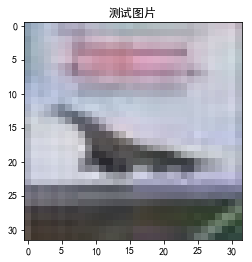

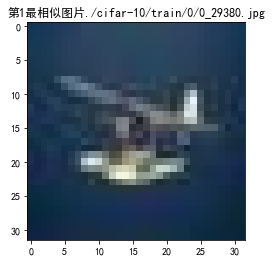

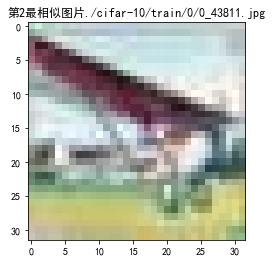

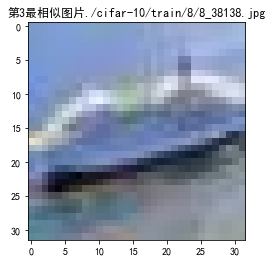

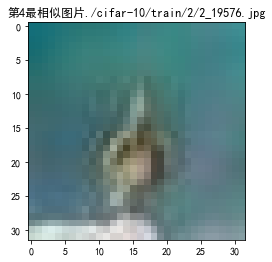

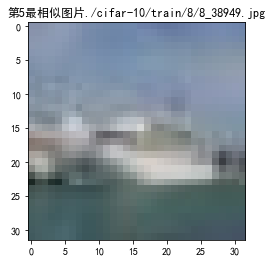

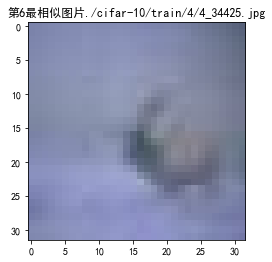

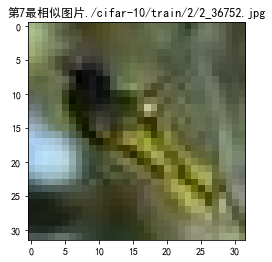

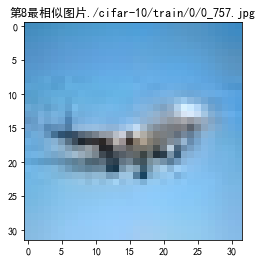

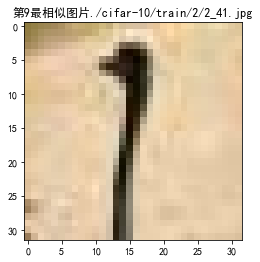

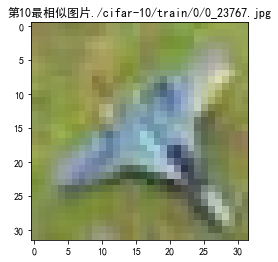

In [116]:
# indices[0]是测试例
top_k = [int(s[int(i)].split('/')[-1][0]) for i in indices[0][1:]]
print(top_k)
print("前{}个最近邻中，有{}个同类别，精确率为{}".
      format(k_, np.sum(np.asarray(top_k)==0), np.sum(np.asarray(top_k)==0)/k_))
test_img = cv2.imread(s[0]).copy()
show(test_img, "测试图片")
for i in range(1, k_+1):
    p = s[int(indices[0][i])]
    result_img = cv2.imread(p).copy()
    show(result_img, "第{}最相似图片".format(i)+p)